<a href="https://colab.research.google.com/github/sgkks/EnvDatSci/blob/main/CodeSprints/FeatureDependence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Feature Dependence and Regression Analysis
In this example, we will be using a spatial dataset of county-level election and demographic statistics for the United States. We'll explore different methods to diagnose and account for multicollinearity in our data in regression analysis. Specifically, we'll calculate variance inflation factor (VIF), and compare parameter estimates and model fit in a multivariate regression predicting 2016 county voting preferences using an OLS model, a ridge regression, a lasso regression, and an elastic net regression.

Objectives:
* **Calculate a variance inflation factor to diagnose multicollinearity.**
* **Interpret model summary statistics.**
* **Describe how multicollinearity impacts stability in parameter esimates.**
* **Explain the variance/bias tradeoff and describe how to use it to improve models**
* **Draw a conclusion based on contrasting models.**



In [ ]:
%%capture
!pip install geopandas
!pip install libpysal

In [ ]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from numpy import mean
from numpy import std
from numpy import absolute
from libpysal.weights.contiguity import Queen
import libpysal
from statsmodels.api import OLS
sns.set_style('white')

First, we're going to load the 'Elections' dataset from the libpysal library, which is a very easy to use API that accesses the Geodata Center at the University of Chicago.

* More on spatial data science resources from UC: https://spatial.uchicago.edu/
* A list of datasets available through lipysal: https://geodacenter.github.io/data-and-lab//

In [ ]:
from libpysal.examples import load_example
elections = load_example('Elections')
#note the folder where your data now lives:


In [ ]:
#First, let's see what files are available in the 'Elections' data example
elections.get_file_list()

['/root/.local/share/pysal/Elections/__MACOSX/election/._election.shp',
 '/root/.local/share/pysal/Elections/election/election.prj',
 '/root/.local/share/pysal/Elections/election/election.shp',
 '/root/.local/share/pysal/Elections/election/election.shx',
 '/root/.local/share/pysal/Elections/election/election.dbf']

When you are out in the world doing research, you often will not find a ready-made function to download your data. That's okay! You know how to get this dataset without using pysal! Do a quick internal review of online data formats and automatic data downloads.

### TASK 1: Use urllib functions to download this file directly from the internet a folder (not in your git repository). Extract the zipped file you've downloaded into a subfolder called elections.

In [44]:
# Task 1 code here:
import urllib.request
import zipfile
import os

# Define the URL of the file to download
url = "https://geodacenter.github.io/data-and-lab//data/election.zip"

# Define the folder to download the file to
folder = "elections_data"

# Create the folder if it doesn't exist
if not os.path.exists(folder):
    os.makedirs(folder)

# Define the path to the downloaded file
filepath = os.path.join(folder, "Elections.zip")

# Download the file
urllib.request.urlretrieve(url, filepath)

# Extract the downloaded file
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(folder, "elections"))

### TASK 2: Use geopandas to read in this shapefile. Call your geopandas.DataFrame "votes"

In [54]:
import os
os.listdir()


['elections_data', 'Elections.zip', 'elections']

<Axes: >

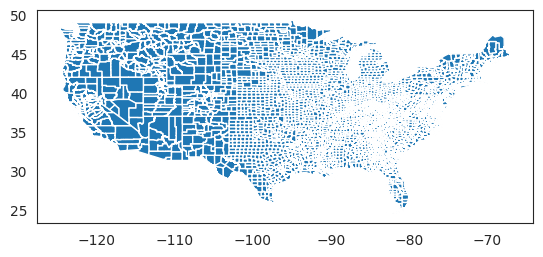

In [55]:
# TASK 2: Use geopandas to read in this shapefile. Call your geopandas.DataFrame "votes"
import os
os.listdir()
os.listdir('elections_data/elections')  # Updated path
votes = gpd.read_file('elections_data/elections/election')  # Updated path
votes.plot()

<Axes: >

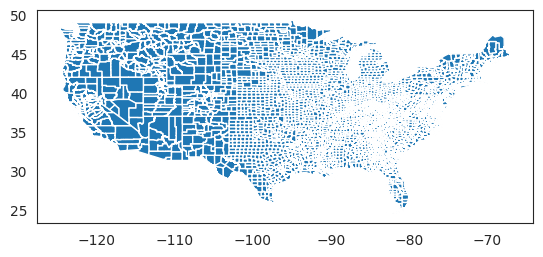

In [56]:
#Let's view the shapefile to get a general idea of the geometry we're looking at:
%matplotlib inline
votes.plot()

In [57]:
#View the first few lines of the dataset
votes.head()

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,total_2012,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,geometry
0,01,005,01005,2.291821e+09,50864677.0,Barbour County,AL,26887.0,27457.0,-2.1,...,11459.0,5873.0,5539.0,5.0,1.0,0.512523,0.483376,334.0,0.029147,"POLYGON ((-85.748 31.619, -85.745 31.619, -85...."
1,01,023,01023,2.365955e+09,19059247.0,Choctaw County,AL,13323.0,13858.0,-3.9,...,7965.0,3785.0,4150.0,23.0,1.0,0.475204,0.521030,365.0,-0.045825,"POLYGON ((-88.473 31.894, -88.469 31.93, -88.4..."
2,01,035,01035,2.201896e+09,6643480.0,Conecuh County,AL,12670.0,13228.0,-4.2,...,7013.0,3551.0,3434.0,35.0,1.0,0.506345,0.489662,117.0,0.016683,"POLYGON ((-87.427 31.264, -87.426 31.268, -87...."
3,01,051,01051,1.601877e+09,99850740.0,Elmore County,AL,80977.0,79296.0,2.1,...,35440.0,8940.0,26223.0,51.0,1.0,0.252257,0.739927,17283.0,-0.487669,"POLYGON ((-86.413 32.751, -86.371 32.751, -86...."
4,01,065,01065,1.667805e+09,32525874.0,Hale County,AL,15184.0,15760.0,-3.7,...,8628.0,5401.0,3205.0,65.0,1.0,0.625985,0.371465,2196.0,0.254520,"POLYGON ((-87.87 32.762, -87.868 32.766, -87.8..."


In [58]:
#Since there are too many columns for us to view on a signle page using "head", we can just print out the column names so we have them all listed for reference
for col in votes.columns:
    print(col)

STATEFP
COUNTYFP
GEOID
ALAND
AWATER
area_name
state_abbr
PST045214
PST040210
PST120214
POP010210
AGE135214
AGE295214
AGE775214
SEX255214
RHI125214
RHI225214
RHI325214
RHI425214
RHI525214
RHI625214
RHI725214
RHI825214
POP715213
POP645213
POP815213
EDU635213
EDU685213
VET605213
LFE305213
HSG010214
HSG445213
HSG096213
HSG495213
HSD410213
HSD310213
INC910213
INC110213
PVY020213
BZA010213
BZA110213
BZA115213
NES010213
SBO001207
SBO315207
SBO115207
SBO215207
SBO515207
SBO415207
SBO015207
MAN450207
WTN220207
RTN130207
RTN131207
AFN120207
BPS030214
LND110210
POP060210
Demvotes16
GOPvotes16
total_2016
pct_dem_16
pct_gop_16
diff_2016
pct_pt_16
total_2012
Demvotes12
GOPvotes12
county_fip
state_fips
pct_dem_12
pct_gop_12
diff_2012
pct_pt_12
geometry


#### You can use pandas summary statistics to get an idea of how county-level data varies across the United States.
### TASK 3: For example, how did the county mean percent Democratic vote change between 2012 (pct_dem_12) and 2016 (pct_dem_16)?

Look here for more info on pandas dataframes:

https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/pandas-dataframes/run-calculations-summary-statistics-pandas-dataframes/

In [62]:
#Task 3
mean_2012 = votes['pct_dem_12'].mean()
mean_2016 = votes['pct_dem_16'].mean()
change = mean_2016 - mean_2012
print("The mean percent democratic vote in 2012 was", mean_2012)
print("The mean percent democratic vote in 2016 was", mean_2016)
print("The mean percent democratic vote between 2012 and 2016 was", change)


The mean percent democratic vote in 2012 was 0.384501897042471
The mean percent democratic vote in 2016 was 0.31666743004440157
The mean percent democratic vote between 2012 and 2016 was -0.06783446699806944


We can also plot histograms of the data. Below, smoothed histograms from the seaborn package (imported as sns) let us get an idea of the distribution of percent democratic votes in 2012 (left) and 2016 (right).

<ipython-input-63-b863192fa8f9>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])
<ipython-input-63-b863192fa8f9>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])


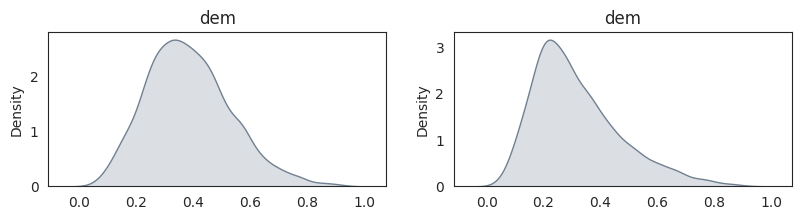

In [63]:
# Plot histograms:
f,ax = plt.subplots(1,2, figsize=(2*3*1.6, 2))
for i,col in enumerate(['pct_dem_12','pct_dem_16']):
    sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])
    ax[i].set_title(col.split('_')[1])

<ipython-input-64-0983810e07fe>:8: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
<ipython-input-64-0983810e07fe>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
<ipython-input-64-0983810e07fe>:8: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
<ipython-input-64-0983810e07fe>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; p

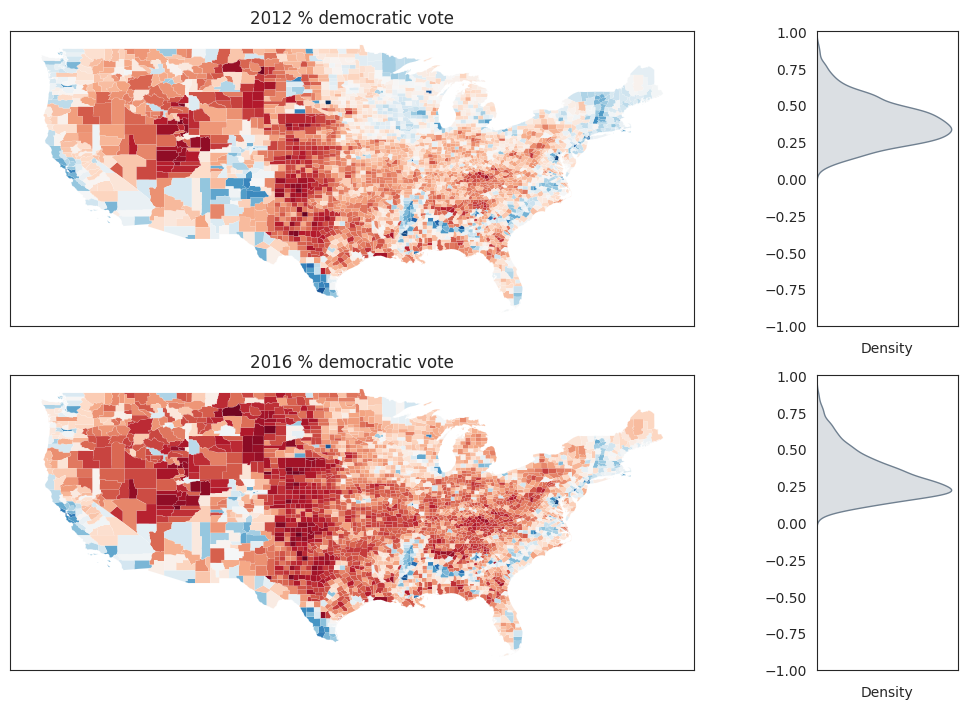

In [64]:
# Plot spatial distribution of # dem vote in 2012 and 2016 with histogram.
f,ax = plt.subplots(2,2, figsize=(1.6*6 + 1,2.4*3), gridspec_kw=dict(width_ratios=(6,1)))
for i,col in enumerate(['pct_dem_12','pct_dem_16']):
    votes.plot(col, linewidth=.05, cmap='RdBu', ax=ax[i,0])
    ax[i,0].set_title(['2012','2016'][i] + " % democratic vote")
    ax[i,0].set_xticklabels('')
    ax[i,0].set_yticklabels('')
    sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
    ax[i,1].set_xticklabels('')
    ax[i,1].set_ylim(-1,1)
f.tight_layout()
plt.show()

### TASK 4: Make a new column on your geopandas dataframe called "pct_dem_change" and plot it using the syntax above. Explain the plot.

<ipython-input-66-4d916e13a673>:8: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['pct_dem_change'].values, ax=ax[1], vertical=True, shade=True, color='slategrey')
<ipython-input-66-4d916e13a673>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['pct_dem_change'].values, ax=ax[1], vertical=True, shade=True, color='slategrey')


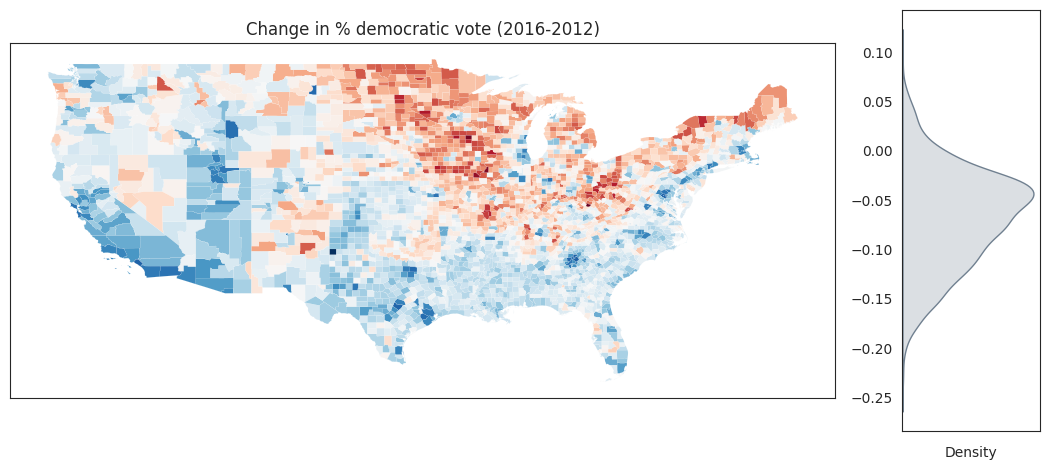

In [66]:
# Task 4: add new column pct_dem_change to votes:
votes['pct_dem_change'] = votes['pct_dem_16'] - votes['pct_dem_12']
f,ax = plt.subplots(1,2, figsize=(1.6*6 + 1,1.6*3), gridspec_kw=dict(width_ratios=(6,1)))
votes.plot('pct_dem_change', linewidth=.05, cmap='RdBu', ax=ax[0])
ax[0].set_title("Change in % democratic vote (2016-2012)")
ax[0].set_xticklabels('')
ax[0].set_yticklabels('')
sns.kdeplot(votes['pct_dem_change'].values, ax=ax[1], vertical=True, shade=True, color='slategrey')
ax[1].set_xticklabels('')
f.tight_layout()
plt.show()

<ipython-input-68-55374da248c0>:7: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['pct_dem_change'].values, ax=ax[1], vertical=True, shade=True, color='slategrey')  # KDE plot on ax[1]
<ipython-input-68-55374da248c0>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['pct_dem_change'].values, ax=ax[1], vertical=True, shade=True, color='slategrey')  # KDE plot on ax[1]


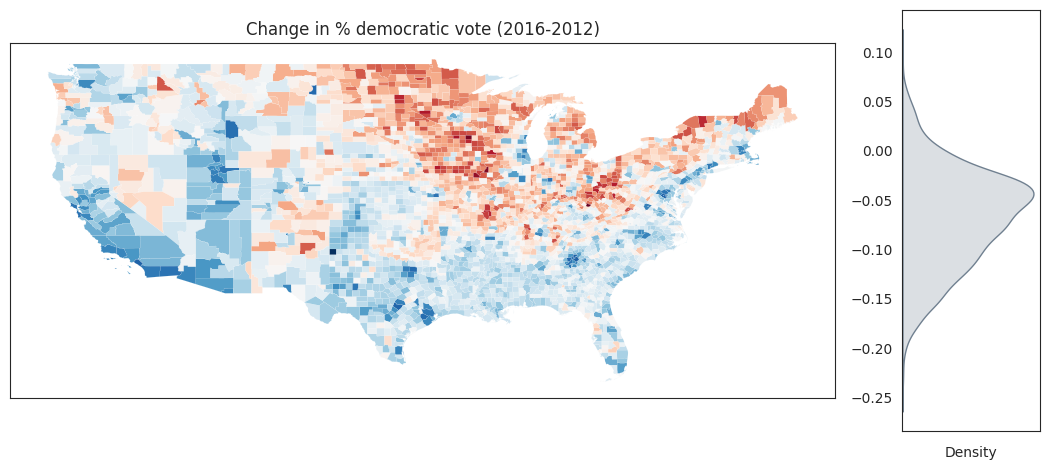

In [68]:
#Task 4: plot your pct_dem_change variable on a map:
f,ax = plt.subplots(1,2, figsize=(1.6*6 + 1,1.6*3), gridspec_kw=dict(width_ratios=(6,1)))
votes.plot('pct_dem_change', linewidth=.05, cmap='RdBu', ax=ax[0])  # Plotting on ax[0]
ax[0].set_title("Change in % democratic vote (2016-2012)")
ax[0].set_xticklabels('')
ax[0].set_yticklabels('')
sns.kdeplot(votes['pct_dem_change'].values, ax=ax[1], vertical=True, shade=True, color='slategrey')  # KDE plot on ax[1]
ax[1].set_xticklabels('')
f.tight_layout()
plt.show()



Click on this url to learn more about the variables in this dataset: https://geodacenter.github.io/data-and-lab//county_election_2012_2016-variables/

Let's say we want to learn more about what county-level factors influence percent change in democratic vote between (pct_dem_change).

There are two types of multicollinearity:

* *Intrinsic multicollinearity:* is an artifact of how we make observations. Often our measurements serve as proxies for some latent process (for example, we can measure percent silt, percent sand, and percent clay as proxies for the latent variable of soil texture). There will be slight variability in the information content between each proxy measurement, but they will not be independent of one another.

* *Incidental collinearity:* is an artifact of how we sample complex populations. If we collect data from a subsample of the landscape where we don't see all combinations of our predictor variables (do not have good cross replication across our variables). We often induce collinearity in our data just because we are limitted in our ability to sample the environment at the scale of temporal/spatial variability of our process of interest. Incidental collinearity is a model formulation problem.(See here for more info on how to avoid it: https://people.umass.edu/sdestef/NRC%20601/StudyDesignConcepts.pdf)

### TASK 5: Looking at the data description, pick two variables that you believe will be intrinsically multicollinear. List and describe these variables. Why do you think they are intrinsically related?

EDU685213: Bachelors degree or higher, percent of persons age 25+, 2009-2013.

INC910213: Per capita money income in past 12 months, 2009-2013.

These two variables tend to be intrinsically multicollinear because higher income level is oftentimes associated with higher levels of education.

## Multivariate regression in observational data:
Our next step is to formulate our predictive/diagnostic model. We want to create a subset of the "votes" geopandas data frame that contains ten predictor variables and our response variable (pct_pt_16) two variables you selected under TASK 1. First, create a list of the variables you'd like to select.

### TASK 6: Create a subset of votes called "my_list" containing only your selected predictor variables. Make sure you use the two variables selected under TASK 5, and eight additional variables

In [70]:
# Task 4: create a subset of votes called "my list" with all your subset variables.
#my_list = ["pct_pt_16", <list your variables here>]

#For example:
my_list = [
    "pct_dem_change",  # Response variable
    "EDU685213",  # Bachelor’s degree or higher, percent of persons age 25+, 2009-2013 (Intrinsically multicollinear)
    "INC910213",  # Per capita money income in past 12 months (2013 dollars), 2009-2013 (Intrinsically multicollinear)
    "HSG010214",  # Housing units, 2014
    "HSG445213",  # Median gross rent, 2009-2013
    "HSG495213",  # Median value of owner-occupied housing units, 2009-2013
    "LND110210",  # Land area in square miles, 2010
    "POP060210",  # Population per square mile, 2010
    "PVY020213",   # Persons below poverty level, percent, 2009-2013
    "BZA010213",  # Private nonfarm establishments, 2013
    "BZA110213", # Private nonfarm employment,  2013
]



In [71]:
#check to make sure all your columns are there:
votes[my_list].head()

,pct_dem_change,EDU685213,INC910213,HSG010214,HSG445213,HSG495213,LND110210,POP060210,PVY020213,BZA010213,BZA110213
0,-0.045920,13.4,16829.0,11799.0,67.7,89200.0,884.88,31.0,26.7,464.0,6611.0
1,-0.047438,11.8,20323.0,7231.0,83.7,58200.0,913.50,15.2,21.5,255.0,2900.0
2,-0.037294,8.8,15605.0,7055.0,79.1,69600.0,850.16,15.6,32.7,194.0,2197.0
3,-0.023670,21.0,23856.0,33326.0,75.5,144600.0,618.49,128.2,13.4,1135.0,14056.0
4,-0.030230,12.8,18812.0,7639.0,78.0,79900.0,643.94,24.5,26.6,195.0,1966.0


### Scatterplot matrix
We call the process of getting to know your data (ranges and distributions of the data, as well as any relationships between variables) "exploratory data analysis". Pairwise plots of your variables, called scatterplots, can provide a lot of insight into the type of relationships you have between variables. A scatterplot matrix is a pairwise comparison of all variables in your dataset.

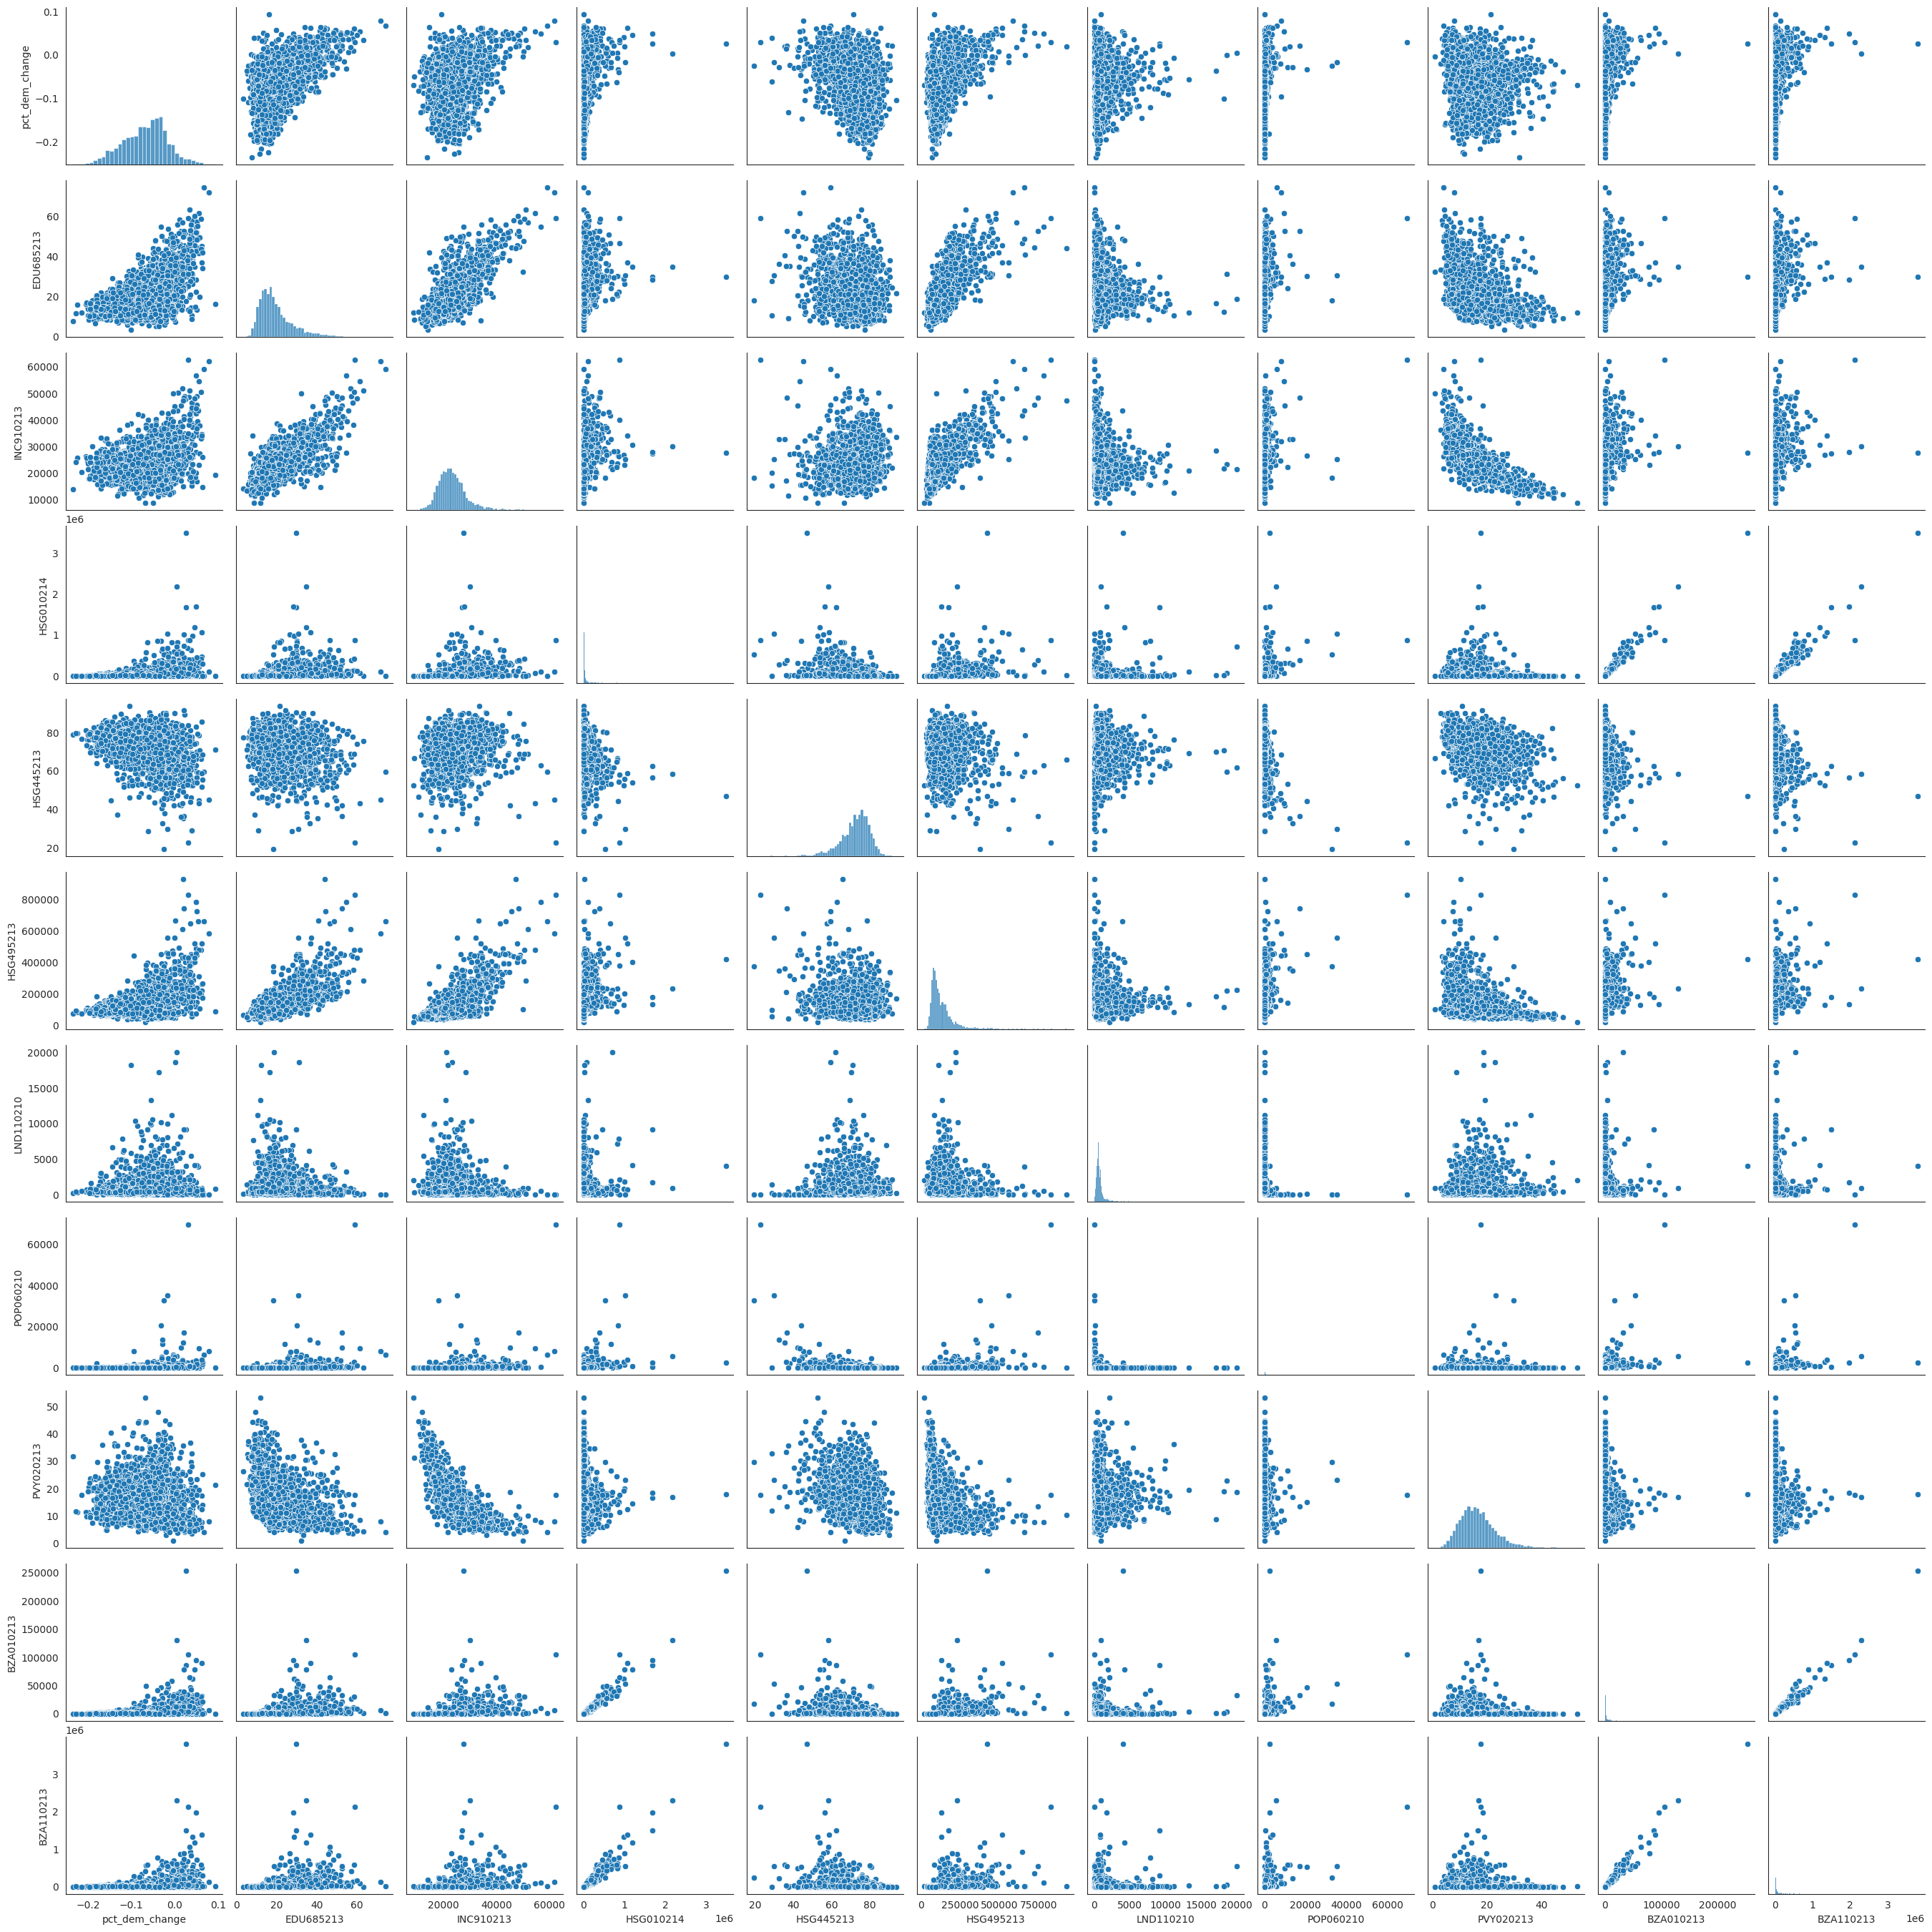

In [72]:
#Use seaborn.pairplot to plot a scatterplot matrix of you 10 variable subset:
sns.pairplot(votes[my_list])

### TASK 7: Do you observe any collinearity in this dataset? How would you describe the relationship between your two "incidentally collinear" variables that you selected based on looking at variable descriptions?

Yes, I do observe collinearity in this dataset. The relationship seems to be a positive linear relationship, which the hypothesis of higher income being associated with the higher level of education.


### TASK 8: What is plotted on the diagonal panels of the scatterplot matrix?

They represent histograms which reflects the distribution of each variable individually.

## Diagnosing collinearity globally:
Variance Inflation Factor describes the magnitude of variance inflation that can be expected in an OLS parameter estimate for a given variable *given pairwise collinearity between that variable and another variable*.

In [73]:
#VIF = 1/(1-R2) of a pairwise OLS regression between two predictor variables
#We can use a built-in function "variance_inflation_factor" from statsmodel.api to calculate VIF
#Learn more about the function
?variance_inflation_factor

In [74]:
#Calculate VIFs on our dataset
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(votes[my_list[1:11]].values, i) for i in range(votes[my_list[1:11]].shape[1])]
vif["features"] = votes[my_list[1:11]].columns


In [75]:
vif.round()

,VIF Factor,features
0,23.0,EDU685213
1,93.0,INC910213
2,25.0,HSG010214
3,60.0,HSG445213
4,11.0,HSG495213
5,2.0,LND110210
6,2.0,POP060210
7,8.0,PVY020213
8,52.0,BZA010213
9,35.0,BZA110213


### Collinearity is always present in observational data. When is it a problem?
Generally speaking, including any variables with VIF > 10 is considered "too much" collinearity. But this value is somewhat arbitrary. The extent to which variance inflation will impact your analysis is highly context dependent. There are two primary contexts where variance inflation is problematic:

 1\. **You are using your analysis to evaluate variable importance:** If you are using parameter estimates from your model to diagnose which observations have physically important relationships with your response variable, variance inflation can make an important predictor look unimportant, and parameter estimates will be highly leveraged by small changes in the data.

 2\. **You want to use your model to make predictions in a situation where the specific structure of collinearity between variables may have shifted:** When training a model on collinear data, the model only applies to data with that exact structure of collinearity.

### Caluculate a linear regression on the global data:
In this next step, we're going to calculate a linear regression in our data an determine whether there is a statistically significant relationship between per capita income and percent change in democratic vote.

In [76]:
#first, forumalate the model. See weather_trend.py in "Git_101" for a refresher on how.

#extract variable that you want to use to "predict"
X = np.array(votes[my_list[1:11]].values)
#standardize data to assist in interpretation of coefficients
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

#extract variable that we want to "predict"
Y = np.array(votes['pct_dem_change'].values)
#standardize data to assist in interpretation of coefficients
Y = (Y - np.mean(X)) / np.std(Y)

lm = OLS(Y,X)
lm_results = OLS(Y,X).fit().summary()

In [77]:
print(lm_results)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.112
Model:                            OLS   Adj. R-squared (uncentered):              0.109
Method:                 Least Squares   F-statistic:                              38.89
Date:                Thu, 14 Nov 2024   Prob (F-statistic):                    1.08e-72
Time:                        17:29:43   Log-Likelihood:                         -5866.9
No. Observations:                3108   AIC:                                  1.175e+04
Df Residuals:                    3098   BIC:                                  1.181e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### TASK 9: Answer: which coefficients indicate a statisticall significant relationship between parameter and pct_dem_change? What is your most important predictor variable? How can you tell?

All variables present in the 'my_list' subset have p-values less than 0.05 except POP060210, indicating significant relationship with response variable 'pct_dem_change'.

The most important predictor variable seems to be EDU685213 (Bachelor’s degree or higher, percent of persons age 25+, 2009-2013).

This predictor variable has the largest absolute value of the standardized coefficient and the magnitude of effect on pct_dem_change seems to be larger.


### TASK10:  Are any of these parameters subject to variance inflation? How can you tell?

Yes - following parameters are subject to variance inflation:

EDU685213: VIF = 19.0
INC910213: VIF = 14.0
HSG495213: VIF = 11.0

The VIF values are greater than 10, which indicates significant variance inflation for these parameters.

**With a cutoff of VIF=10, the following variables are subject to variable inflation.**

	269.0 	SEX255214
	119.0 	RHI125214
	20.0 	EDU685213
	11.0 	HSG495213
	106.0 	HSD310213
	67.0 	INC910213

Now, let's plot our residuals to see if there are any spatial patterns in them.

Remember residuals = predicted - fitted values

In [78]:
#Add model residuals to our "votes" geopandas dataframe:
votes['lm_resid']=OLS(Y,X).fit().resid


In [79]:
vif['OLS_coef']=OLS(Y,X).fit().params

<ipython-input-80-a8779e0e0e57>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')


<Axes: ylabel='Density'>

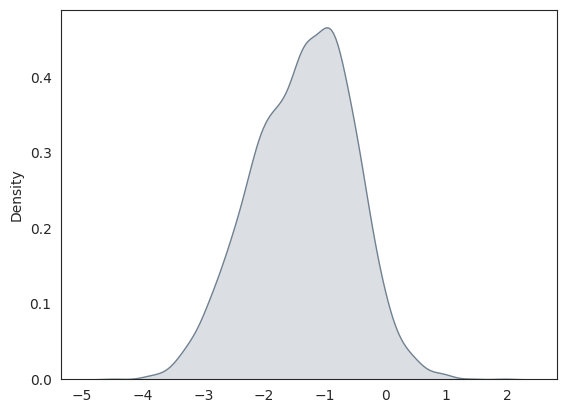

In [80]:
sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')


### TASK 11: Are our residuals normally distributed with a mean of zero? What does that mean?

Yes, they are normally distributed with a mean close to zero. This means that the assumptions of linear regression model are met in terms of residual normality and mean.



## Penalized regression: ridge penalty
In penalized regression, we intentionally bias the parameter estimates to stabilize them given collinearity in the dataset.

From https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

>As mentioned before, ridge regression performs ‘L2 regularization‘, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. Thus, ridge regression optimizes the following:

**Objective = RSS + α * (sum of square of coefficients)**

Here, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. α can take various values:

* **α = 0:** The objective becomes same as simple linear regression. We’ll get the same coefficients as simple linear regression.

* **α = ∞:** The coefficients will approach zero. Why? Because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.

* **0 < α < ∞:** The magnitude of α will decide the weightage given to different parts of objective. The coefficients will be somewhere between 0 and ones for simple linear regression."

In other words, the ridge penalty shrinks coefficients such that collinear coefficients will have more similar coefficient values. It has a "grouping" tendency.

In [81]:
# when L2=0, Ridge equals OLS
model = Ridge(alpha=1)

In [82]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.672 (0.025)


In [83]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)


[ 0.46551814 -0.12067184  0.15650533 -0.090892    0.17528623  0.03946811
 -0.05771071  0.18328128 -0.18590305  0.13282396]


### Hyperparameter tuning
The L2 coefficient (called alpha above) is a free parameter (hyperparameter) in the model, meaning we can set it whatever value we feel is best.

In machine learning, we often try multiple options for these hyperparameters, and select the value with the highest model performance.

In [84]:
# Train on a range of alphas
alpha = np.arange(0,20,0.1)
ridge_tune=pd.DataFrame(alpha, columns=["alpha"])
ridge_tune['Score']=0
i=0
for a in alpha:
  model= Ridge(alpha=a)
  oos_scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  #force scores to be positive
  oos_scores = absolute(oos_scores)
  ridge_tune.Score.loc[i]=mean(oos_scores)
  i=i+1


<ipython-input-84-b880491338e4>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ridge_tune.Score.loc[i]=mean(oos_scores)
<ipython-input-84-b880491338e4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

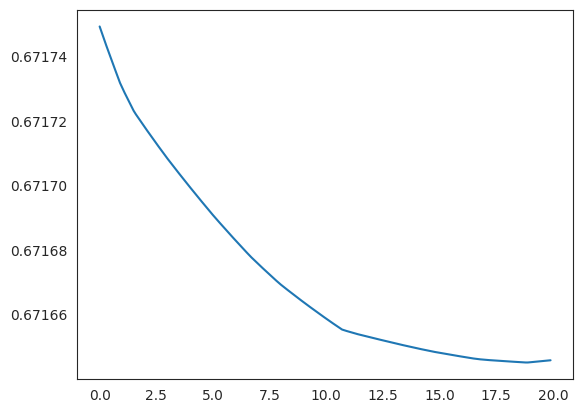

In [85]:
#  Plot model performance as a function of alpha
plt.plot(ridge_tune.alpha, ridge_tune.Score)
plt.show()
# What is the y-axis label? What is the x-axis label?

In [86]:
# Select the value of alpha which minimizes MAE
a2 = ridge_tune.alpha.iloc[ridge_tune['Score'].idxmin()]
a2

18.8

In [87]:
# Train model with optimized alpha
model = Ridge(alpha=a2)
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
vif['Ridge_coef']=model.coef_

[ 0.45710406 -0.11114661  0.13020858 -0.09460397  0.17113029  0.03963615
 -0.05765985  0.18350252 -0.12360409  0.09686125]


## Penalized regression: lasso penalty

From https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/
> LASSO stands for Least Absolute Shrinkage and Selection Operator.

There are 2 key words here – **absolute** and **selection**.

Lets consider the former first and worry about the latter later.
.
Lasso regression performs L1 regularization, i.e. it adds a factor to the sum of absolute value of coefficients in the optimization objective. Thus, lasso regression optimizes the following:

**Objective = RSS + α * (sum of absolute value of coefficients)**

Here, α (alpha) works similar to that of ridge and provides a trade-off between balancing RSS and magnitude of coefficients. Like that of ridge, α can take various values. Lets iterate it here briefly:

* **α = 0:** Same coefficients as simple linear regression
* **α = ∞:** All coefficients zero (same logic as before)
* **0 < α < ∞:** coefficients between 0 and that of simple linear regression

The lasso penalty shrinks unimportant coefficients down towards zero, automatically "selecting" important predictor variables. But what if that shrunken coefficient is induced by incidental collinearity (i.e. is a feature of how we sampled our data)?

In [88]:
# when L1=0, Lasso equals OLS
model = Lasso(alpha=0)

In [89]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.672 (0.024)


In [90]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare to OLS coefficients?

[ 0.46597951 -0.12125675  0.15854574 -0.09064997  0.1756111   0.03945264
 -0.05772159  0.18325545 -0.19093545  0.13581881]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+03, tolerance: 3.108e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

In [91]:
# when L1 approaches infinity, coefficients will become exactly zero, and MAE equals the variance of our response variable:
model = Lasso(alpha=10000000)

In [92]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.808 (0.038)


In [93]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare with OLS coefficients above?

[ 0.  0.  0. -0.  0.  0.  0.  0.  0.  0.]


### Hyperparameter tuning
Just like with the ridge penalty, we want to select the value of alpha that minimizes error in the lasso model.

We'll use hyperparameter tuning again to do this:

In [94]:
# Define range of alphas:
alpha = np.arange(0,.02,0.0001)
lasso_tune=pd.DataFrame(alpha, columns=["alpha"])
lasso_tune['Score']=0
i=0
for a in alpha:
  model= Lasso(alpha=a)
  oos_scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  #force scores to be positive
  oos_scores = absolute(oos_scores)
  lasso_tune.Score.loc[i]=mean(oos_scores)
  i=i+1


<ipython-input-94-c8b914a87dd9>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  lasso_tune.Score.loc[i]=mean(oos_scores)
<ipython-input-94-c8b914a87dd9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

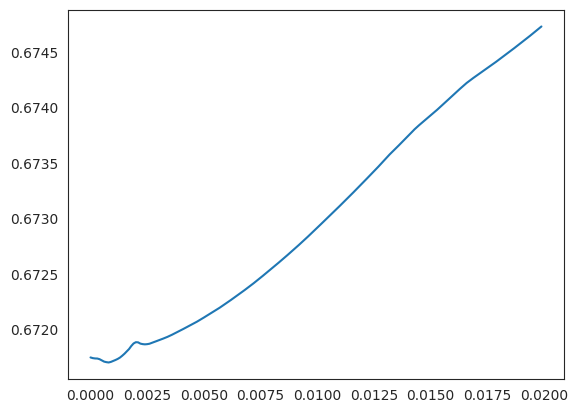

In [95]:
# Plot model performance as a function of alpha:
plt.plot(lasso_tune.alpha, lasso_tune.Score)
plt.show()
# What is the y-axis label? What is the x-axis label?

In [96]:
a1 = lasso_tune.alpha.iloc[lasso_tune['Score'].idxmin()]
a1

0.0008

In [97]:
# Train model with optimal alpha1
model= Lasso(alpha=a1)
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)

vif['LASSO_coef']= model.coef_

[ 0.46445679 -0.11501446  0.129719   -0.09225282  0.16886902  0.03929946
 -0.05601773  0.18415734 -0.1134426   0.08661405]


### Penalized regression: elastic net penalty

In other words, the lasso penalty shrinks unimportant coefficients down towards zero, automatically "selecting" important predictor variables. The ridge penalty shrinks coefficients of collinear predictor variables nearer to each other, effectively partitioning the magnitude of response from the response variable between them, instead of "arbitrarily" partitioning it to one group.

We can also run a regression with a linear combination of ridge and lasso, called the elastic net, that has a cool property called "group selection."

The ridge penalty still works to distribute response variance equally between members of "groups" of collinear predictor variables. The lasso penalty still works to shrink certain coefficients to exactly zero so they can be ignored in model formulation. The elastic net produces models that are both sparse and stable under collinearity, by shrinking parameters of members of unimportant collinear predictor variables to exactly zero:

In [98]:
# Explore the parameters in the ElasticNet fuction.
# Which variable represents the ridge coefficient? Which parameter represents the lasso coefficient?
?ElasticNet

In [99]:
# when L1 approaches infinity, certain coefficients will become exactly zero, and MAE equals the variance of our response variable:
model = ElasticNet(alpha=.1, l1_ratio=.1)

In [100]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.676 (0.026)


In [101]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare with OLS coefficients above?
vif["ElNet_coef"]=model.coef_

[ 0.3433831  -0.00046416  0.06764458 -0.12023945  0.13566743  0.03315401
 -0.03689245  0.17017404  0.          0.0264688 ]


### TASK 12: Match these elastic net coefficients up with your original data. Do you see a logical grouping(s) between variables that have non-zero coefficients?

Yes, the following logical groups are observed:

1. Education and Income: EDU685213 (Bachelor’s degree or higher) and INC910213 (Per capita income) both have positive coefficients, which indicated that higher levels of education and income are associated with an increase in pct_dem_change.

2. Population Density and Poverty: POP060210 (Population per square mile) and PVY020213 (Persons below poverty level) have negative coefficients suggesting that higher population density and poverty rates are associated with a decrease in pct_dem_change.

3.

In [102]:
print(vif)

   VIF Factor   features  OLS_coef  Ridge_coef  LASSO_coef  ElNet_coef
0   22.690880  EDU685213  0.465980    0.457104    0.464457    0.343383
1   92.825974  INC910213 -0.121257   -0.111147   -0.115014   -0.000464
2   25.101865  HSG010214  0.158546    0.130209    0.129719    0.067645
3   59.944159  HSG445213 -0.090650   -0.094604   -0.092253   -0.120239
4   11.309790  HSG495213  0.175611    0.171130    0.168869    0.135667
5    1.586468  LND110210  0.039453    0.039636    0.039299    0.033154
6    1.537464  POP060210 -0.057722   -0.057660   -0.056018   -0.036892
7    8.498106  PVY020213  0.183255    0.183503    0.184157    0.170174
8   51.635592  BZA010213 -0.190935   -0.123604   -0.113443    0.000000
9   35.170736  BZA110213  0.135819    0.096861    0.086614    0.026469


## Extra Credit:
We saw how to tune individual parameters above. The elastic net regression here has two free parameters. How can you select the best values for these two free parameters?

Demonstrate in the cell below.

In [105]:
# Extra credit scratch cell:
# Define ranges for alpha and l1_ratio
alphas = np.arange(0.01, 1, 0.05)  # Example range for alpha
l1_ratios = np.arange(0.1, 1, 0.1)  # Example range for l1_ratio

# Create a grid of hyperparameter combinations
from itertools import product
param_grid = list(product(alphas, l1_ratios))

# Initialize variables to store best results
best_score = float('inf')  # Start with a very high score to minimize
best_params = {}

# Iterate through the grid, evaluating each combination
for alpha, l1_ratio in param_grid:
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores = absolute(scores)  # Force scores to be positive (MAE)
    avg_score = mean(scores)

    # Check if current score is better than the best so far
    if avg_score < best_score:
        best_score = avg_score
        best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}

        # Train the final model with the best hyperparameters
final_model = ElasticNet(**best_params)  # Use ** to unpack the dictionary
final_model.fit(X, Y)

print("Best hyperparameters:", best_params)
print("Best score (MAE):", best_score)

Best hyperparameters: {'alpha': 0.01, 'l1_ratio': 0.1}
Best score (MAE): 0.6717560175033256
